# Train an image classifier on the NACTI subset

We'll use the fantastic fastai library as much as possible, especially for the actual hard parts (esp. training and creating the "dataloaders").

Links:
- [NACTI dataset on LILA](https://lila.science/datasets/nacti)
- [COCO data format](https://cocodataset.org/#format-data)
- [COCO Camera Trap data format](https://github.com/Microsoft/CameraTraps/blob/master/data_management/README.md#coco-cameratraps-format)

In [20]:
from fastai.vision.all import *
from collections import defaultdict, Counter

DATA = Path("/home/rory/data")
NACTI = DATA / "nacti"

In [ ]:
def load_json(path):
    return json.load(open(path))

# ETL

First, let's take a peek at the directory structure to remind ourselves what's what.

In [3]:
list(NACTI.ls())

[Path('/home/rory/data/nacti/models'),
 Path('/home/rory/data/nacti/backups'),
 Path('/home/rory/data/nacti/imgs'),
 Path('/home/rory/data/nacti/bad_imgs'),
 Path('/home/rory/data/nacti/bad_paths-empty.txt'),
 Path('/home/rory/data/nacti/metadata.json'),
 Path('/home/rory/data/nacti/metadata.json.zip'),
 Path('/home/rory/data/nacti/downloads'),
 Path('/home/rory/data/nacti/lila_sas_urls.txt'),
 Path('/home/rory/data/nacti/bad_img_files.txt'),
 Path('/home/rory/data/nacti/urls_to_download-empty.txt'),
 Path('/home/rory/data/nacti/2021-12-13-1830_cats6_err036')]

In [4]:
list((NACTI/"imgs").ls())

[Path('/home/rory/data/nacti/imgs/part0'),
 Path('/home/rory/data/nacti/imgs/part1'),
 Path('/home/rory/data/nacti/imgs/part3'),
 Path('/home/rory/data/nacti/imgs/part2')]

Next, let's make a helper function to grab the COCO-style annos and return the list of filenames and the corresponding list of labels. (This function is a modified version of the fastai function `get_annos`).

In [4]:
def get_nacti_annos(path):
    """
    Open a NACTI json in `path` and returns the lists of filenames (with
    maybe `prefix`). Unlike COCO, NACTI labels are single-label.
    Returns fns, lbls.
    """
    cct = load_json(path)
    id2img, id2lbl = {}, defaultdict(None)
    id2cat = {o['id']:o['common name'] for o in cct['categories']}
    
    # populate id2lbl
    for o in cct['annotations']:
        lbl = id2cat[o['category_id']]
        id2lbl[o['image_id']] = lbl
    
    # populate id2img
    id2img = {o['id'] : o['file_name'] for o in cct['images'] if o['id'] in id2lbl}
    
    # iterate through IDs to return img and annos
    ids = list(id2img.keys())
    return [id2img[i] for i in ids], [id2lbl[i] for i in ids]

I had to write another helper to rearrange my images so that they matched the initial stucture they were downloaded in. Don't mess with the directory structures!

In [7]:
def organize_image_files(img_dir=NACTI/"imgs"):
    
    # make name2path: map from name to correct path given by the annos json
    fns, lbls = get_nacti_annos(NACTI/"metadata.json")
    names = L(fns).map(lambda fn: fn.split("/")[2])
    name2path = {f:NACTI/"imgs"/p for f,p in zip(names, fns)}
    
    # get paths to image files
    imgs = get_image_files(img_dir)
    
    # move each image to its correct path
    exceptions = []
    for i,img in enumerate(imgs):
        if i%1000==0: print(i)
            
        name = img.name
        new_path = name2path[name]
        new_parent = new_path.parent
        
        try: os.makedirs(new_parent)
        except: pass

        try: shutil.move(img, name2path[name])
        except Exception as e: exceptions.append(e)

    return exceptions

Now we can use `get_nacti_annos` to get our image files and labels.

In [8]:
fns, lbls = get_nacti_annos(NACTI/"metadata.json")
len(fns), fns[:3] , lbls[:3]

(3382215,
 ['part0/sub000/2010_Unit150_Ivan097_img0001.jpg',
  'part0/sub000/2010_Unit150_Ivan097_img0002.jpg',
  'part0/sub000/2010_Unit150_Ivan097_img0003.jpg'],
 ['red deer', 'red deer', 'red deer'])

In [10]:
fns = L(fns).map(lambda f: f.split("/")[-1])
fns[:3]

(#3) ['2010_Unit150_Ivan097_img0001.jpg','2010_Unit150_Ivan097_img0002.jpg','2010_Unit150_Ivan097_img0003.jpg']

In [11]:
paths = get_image_files(NACTI/"imgs")
len(paths), paths[:3]

(256931,
 (#3) [Path('/home/rory/data/nacti/imgs/part0/sub028/2016_Unit074_Ivan092_img5521.jpg'),Path('/home/rory/data/nacti/imgs/part0/sub028/2016_Unit074_Ivan092_img4468.jpg'),Path('/home/rory/data/nacti/imgs/part0/sub028/2016_Unit074_Ivan092_img4886.jpg')])

In [12]:
fn2lbl = {fn:lbl for fn,lbl in zip(fns,lbls)}
labels = paths.map(lambda p: fn2lbl[p.name])
labels

(#256931) ['mule deer','mule deer','mule deer','mule deer','american black bear','mule deer','mule deer','mule deer','mule deer','mule deer'...]

In [13]:
Counter(labels).most_common()

[('mule deer', 85360),
 ('empty', 54983),
 ('california ground squirrel', 33685),
 ('american black bear', 28678),
 ('vehicle', 25973),
 ('cougar', 14684),
 ('unidentified deer', 7668),
 ('wild turkey', 3636),
 ('california quail', 2264)]

In [14]:
deer = [p for p in paths if fn2lbl[p.name] == 'mule deer']
squirrel = [p for p in paths if fn2lbl[p.name] == 'california ground squirrel']
bear = [p for p in paths if fn2lbl[p.name] == 'american black bear']
vehicle = [p for p in paths if fn2lbl[p.name] == 'vehicle']
cougar = [p for p in paths if fn2lbl[p.name] == 'cougar']
quail = [p for p in paths if fn2lbl[p.name] == 'california quail']
turkey = [p for p in paths if fn2lbl[p.name] == 'wild turkey']
unidentified_deer = [p for p in paths if fn2lbl[p.name] == 'unidentified deer']
empty = [p for p in paths if fn2lbl[p.name] == 'empty']

For the first model, I'm only using a few categories to speed the development loop up.

In [15]:
my_cats = [deer, squirrel, bear, cougar, empty]

I'm going to limit the number of images while balancing the classes (which isn't always necessary in deep learning) to further restrict the size of my dataset to speed up the dev cycle.

In [16]:
max_items = 1_000
subset = L()

for my_cat in my_cats:
    subset += L(my_cat).shuffle()[:max_items]

len(subset)

5000

I'll make sure I only have the labels for images in my subset, too.

In [17]:
subset_labels = subset.map(lambda p: fn2lbl[p.name])

# Dataloaders & Training

Time to use fastai to further format the data and train the model.

In [26]:
dls = ImageDataLoaders.from_lists(
    NACTI,
    subset,
    subset_labels,
    item_tfms=Resize(400),
    batch_tfms=[*aug_transforms(size=256, max_zoom=1.0)],
    bs=64
)

Let's check out some training images:

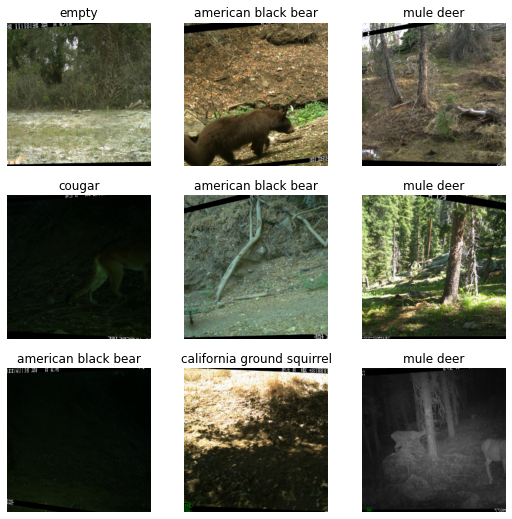

In [27]:
dls.show_batch()

We can now create and train a deep learning model (I'm choosing resnet18 to match the model that's described in the NACTI whitepaper).

In [28]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

We use lr_find to automatically select our learning rate.

/home/rory/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


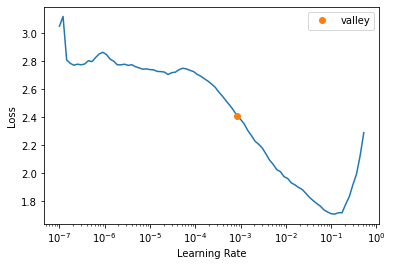

In [22]:
lr = learn.lr_find()

Now we "fine tune" the model, aka train a pretrained model (in order to save us from having to do a ton of computation). The pretrained model was trained using the ImageNet dataset.

In [29]:
learn.fine_tune(5, lr.valley)

For fun, here's the result of training a resnet34 model using the entire subset for 10 epochs. The error rate starts approaching a low enough value that seems like it should be good enough for a production system!

In [37]:
# learn.fine_tune(10, 1e-3) # lr.valley seems to always be approx 1e-3

We're now going to export the model to be used on our trailcam images. (Please excuse my poor choice of filename; the best practice for logging model metadata like categories and model error in a model metadata file instead of the file name, but that level of organization makes more sense for team projects instead of individual projects like this).

In [31]:
learn.export("2021-12-13-1830_cats6_err036")

# Inference

Imports, constants, and utils. We'll use the higher accuracy model I trained instead of the smaller one we used to get the code working.

In [3]:
from fastai.vision.all import *

DATA = Path("/home/rory/data")
MODEL = DATA / "nacti" / "2021-12-13-1830_cats6_err036"
TEST_ANNOS = DATA / "trailcam" / "annos.json"

def load_json(path):
    return json.load(open(path))

We load the weights of the trained model using a helper function from fastai.

In [2]:
inf = load_learner(MODEL)
cats = inf.dls.vocab

cats

['american black bear', 'california ground squirrel', 'cougar', 'empty', 'mule deer', 'vehicle']

I will now load in the annos that I hand-specified using a computer vision annotation tool. These tools are basically just image viewing tools that also let you draw and label rectangles on your images & output the details of those annotations to JSON or CSV. In notebook 02, I show you the CSV my annotation tool gave me via export, and I go through the steps I took to clean it up into the "flat" JSON format you see below.

In [6]:
test = load_json(TEST_ANNOS)

test

{'16372053860754': {'path': '/home/rory/data/trailcam/1637205386_SYFW0754.jpg',
  'width': 1920,
  'height': 1440,
  'cat_ids': [0],
  'cats': ['person'],
  'bboxes': [[1384.6648454157782,
    611.1416709863745,
    182.3074360341152,
    391.18875888625587]]},
 '16372055340757': {'path': '/home/rory/data/trailcam/1637205534_SYFW0757.jpg',
  'width': 1920,
  'height': 1440,
  'cat_ids': [0],
  'cats': ['person'],
  'bboxes': [[638.7143405932655,
    641.1444435473093,
    89.64962753874931,
    266.6625993963827]]},
 '16372057010760': {'path': '/home/rory/data/trailcam/1637205701_SYFW0760.jpg',
  'width': 1920,
  'height': 1440,
  'cat_ids': [0],
  'cats': ['person'],
  'bboxes': [[0.0, 266.7418450418745, 1920.0, 1110.2045560851745]]},
 '16372058090762': {'path': '/home/rory/data/trailcam/1637205809_SYFW0762.jpg',
  'width': 1920,
  'height': 1440,
  'cat_ids': [0],
  'cats': ['person'],
  'bboxes': [[933.7095386825226,
    632.9392303880078,
    89.59175407536077,
    283.919481969440

I'm going to throw away the keys to the test data b/c I don't need them, plus I'd rather have everything in a list format. The `L` class is actually fastai's improvement to the built-in `list` – it does everything `list` does (and stuff like map/filter/reduce) faster.

In [11]:
test = L(test.values())

Here's a little pattern I do in my python notebooks... I init an index to -1, then I keep on running the next cell to cycle through images one-by-one.

In [148]:
i=-1

73 /home/rory/data/trailcam/1637510448_SYFW0959.jpg


american black bear : 0.0
california ground squirrel : 0.02
cougar : 0.03
empty : 0.68
mule deer : 0.16
vehicle : 0.1


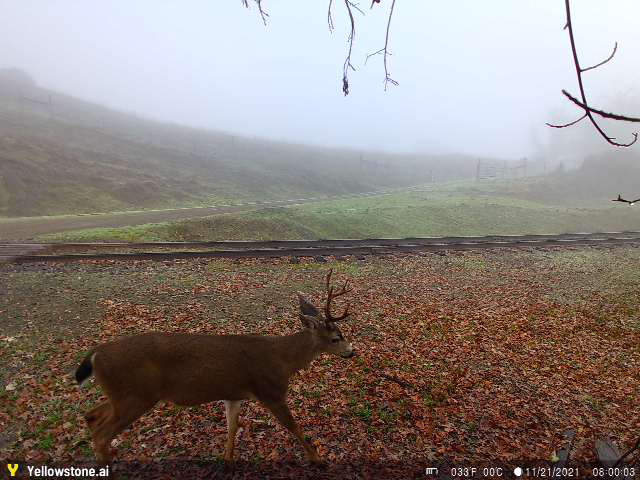

In [171]:
i+=1
path = test[i]['path']
print(i, path)

pred_lbl, conf_idx, confs = inf.predict(path)
pred_conf = round(confs[conf_idx].item(), 2)
for v,c in zip(cats,confs):
    print(v, ":", round(c.item(), 2))
    
load_image(path)

WTF! How does it miss THAT but gets a blurry, partial deer at night?

In [179]:
im = load_image(path)
w,h = im.size

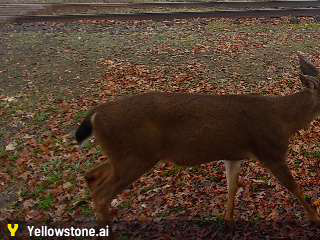

In [194]:
im.crop((0, h/2, w/2, h))

Almost... Just slightly to the right...

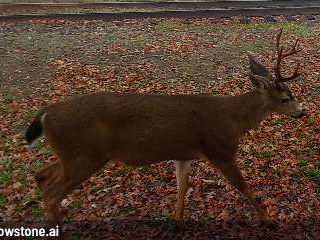

In [193]:
im.crop((0+50, h/2, w/2+50, h))

At'll'do. Let's save it and see what the prediction is for this cropped image.

In [195]:
cropped_fn = "cropped.jpg"
im.crop((0+50, h/2, w/2+50, h)).save(cropped_fn)
inf.predict(cropped_fn)

('mule deer',
 tensor(4),
 tensor([4.2223e-04, 1.1797e-02, 7.7402e-04, 1.7533e-02, 9.6846e-01, 1.0104e-03]))

Bingo – deer at 97%. Out of curiosity, what is the prediction for the roughly-cropped image (missing the deer's face/antlers).

In [196]:
im.crop((0, h/2, w/2, h)).save(cropped_fn)
inf.predict(cropped_fn)

('american black bear',
 tensor(0),
 tensor([0.3029, 0.0887, 0.0427, 0.2931, 0.2143, 0.0584]))

Interesting – you can see from the probabilities that it's split on three of them (black bear "wins" by less than a percentage point).

Let's focus just on preds for images with deer. We'll filter `test` to only include my trailcam images of deer, then we'll make a prediction for each image, then count the predictions by class to get a sense of the overall accuracy.

In [199]:
deer = test.filter(lambda t: 'deer' in t['cats'])
deer_preds = deer.map(lambda d: inf.predict(d['path']))

Counter(deer_preds.map(lambda p: p[0])).most_common()

[('mule deer', 30),
 ('vehicle', 19),
 ('empty', 8),
 ('cougar', 5),
 ('american black bear', 1)]

That's 30/63 = 48% accuracy, which is FAR LESS than what we were lead to believe when training the model! The reason for that is that camera trap models are never as accurate for "out of sample" data (meaning pictures from new locations). The models are only good at classifying images from locations its seen before.

Let's take a look at some predictions to see if we can find a theme.

In [90]:
i=-1

i=41 | vehicle 0.52 | /home/rory/data/trailcam/1637599032_SYFW1004.jpg


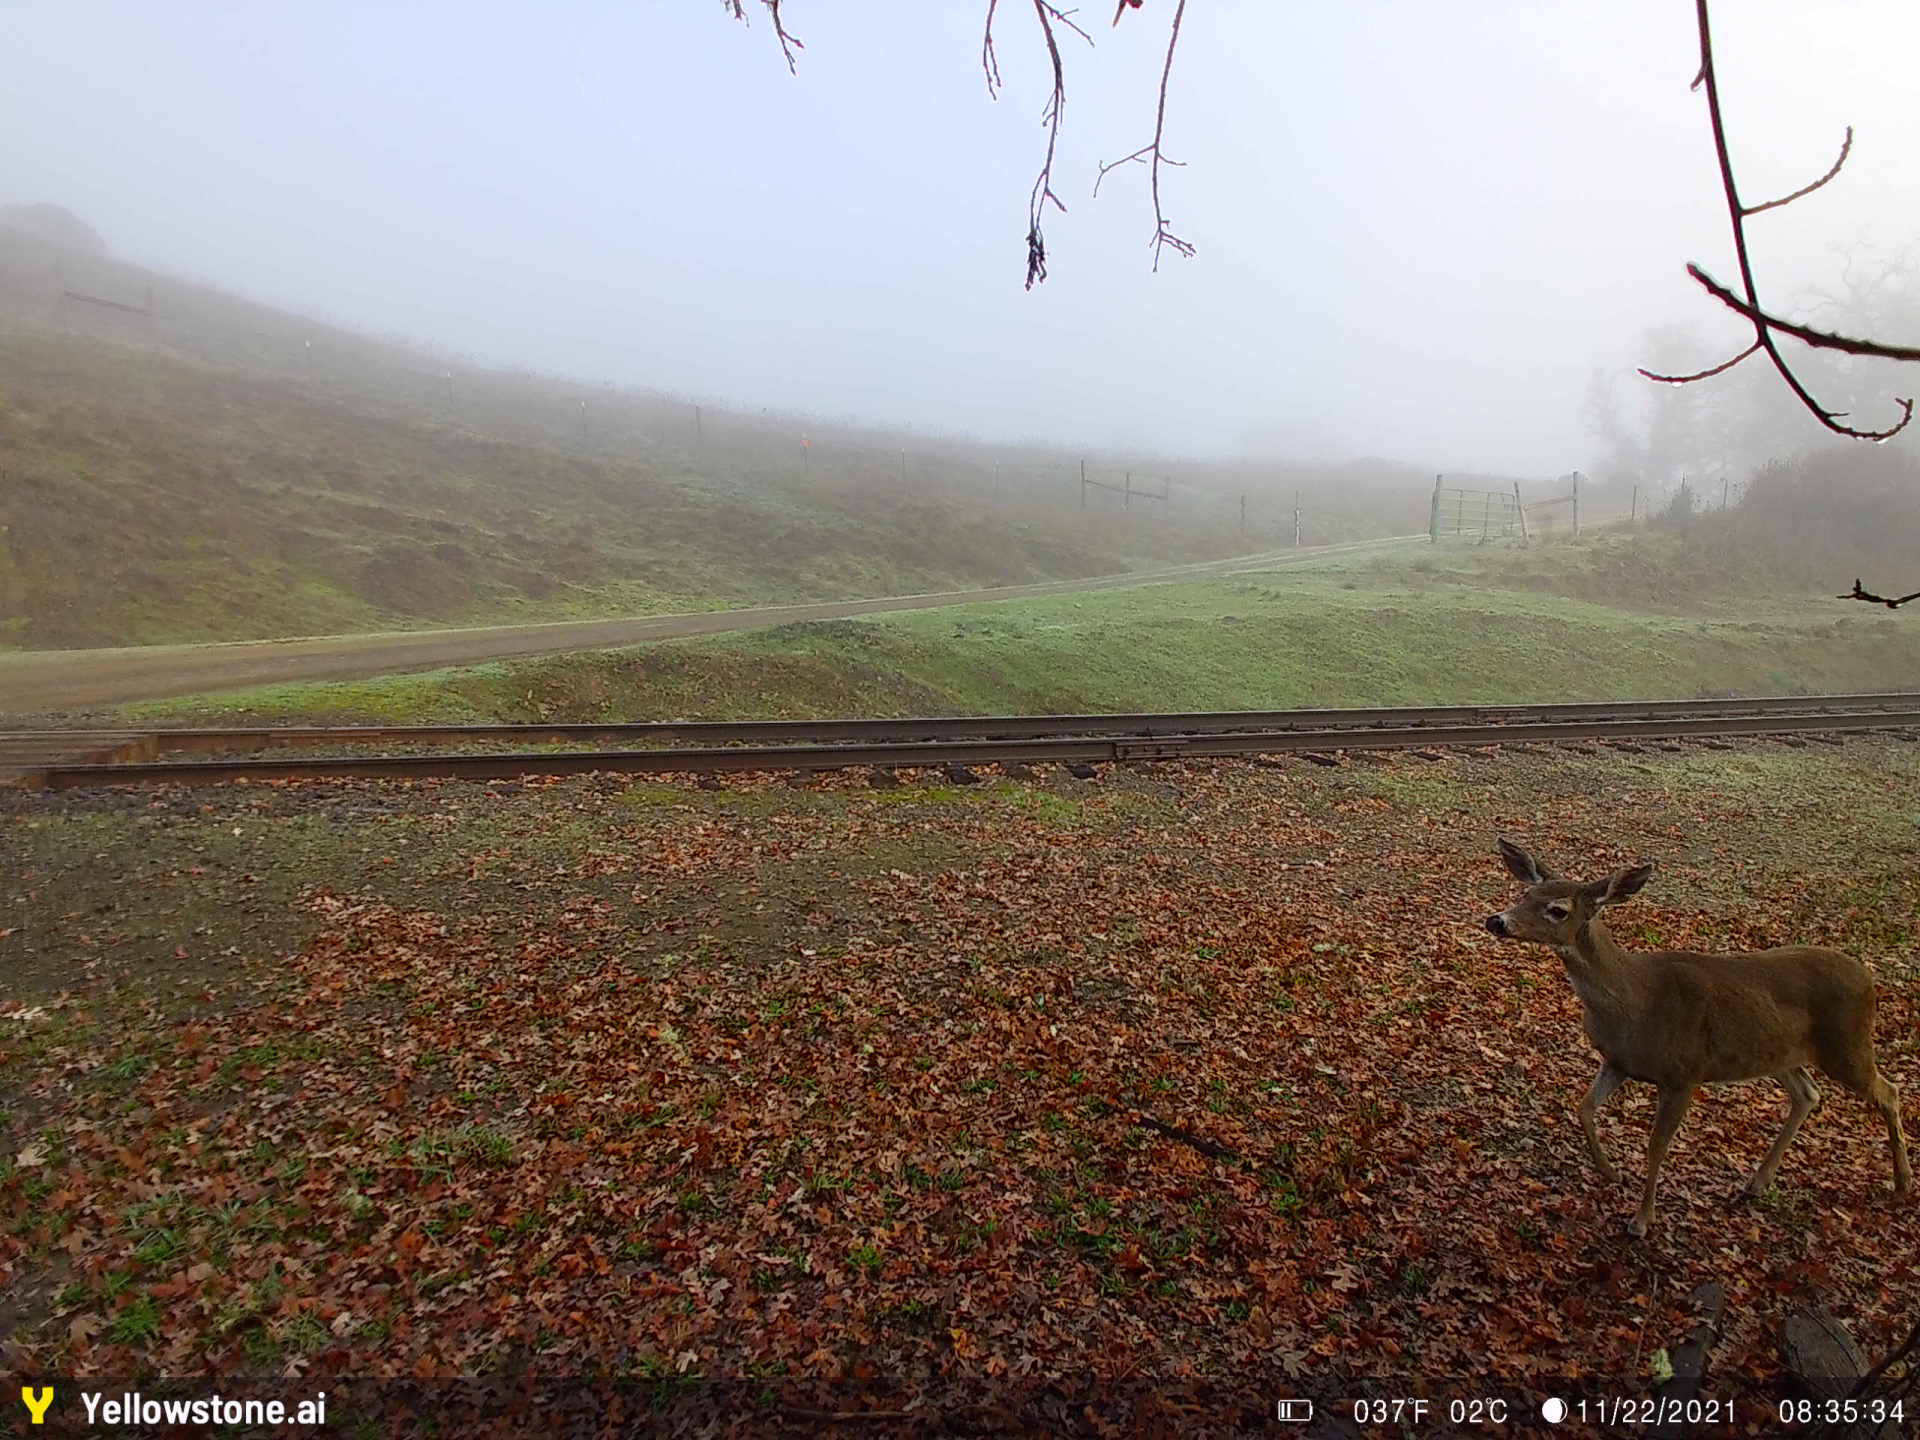

In [143]:
i+=1
path = deer[i]['path']
pred_lbl, conf_idx, confs = inf.predict(path)
pred_conf = round(confs[conf_idx].item(), 2)
print(f"i={i} | {pred_lbl} {pred_conf} | {path}")
load_image(path)

After looking through the images, here's what stood out to me:
- The model was getting the images of deer at night mostly correct. When it was wrong, it was wrong randomly.
- The model was failing to identify images of deer during the day and labeled most of them as "vehicle".
- The images are from a location where both a train track and a dirt road are visible during only the day.

Based on those three points, I believe that the model is seeing the tracks and the road and assuming that the image has a vehicle in it. This is a perfect example of what we mean by a model performing poorly on "out of sample" images.

Along with that issue, I noticed two other interesting things. First, the deer in the leaf-litter are actually quite well hidden! Second, the night images have less landscape detail and more animal detail. These factors probably further contribute to the black-and-white images outperforming.

# Next step: pre-process images with bounding boxes

If I were to improve my predictions further, I'd do the following:
- Train a bounding box model to identify 'vehicle', 'person', and 'animal' to crop each image to specific regions of interest.
- Retrain this classification model for animal labels only using the cropped bounding boxes instead of the entire images.

The above approach seems to have worked well for others and is how the camera trap team at Microsoft built their MegaDetection bounding box model for trailcams. It's actually a common approach to pre-processing image data in many machine learning pipelines.

This notebook by the Microsoft camera trap team shows how to use their pretrained MegaDetection model on any images uploaded to Google Drive: [Megadetector_Colab_test.ipynb](https://colab.research.google.com/github/microsoft/CameraTraps/blob/master/detection/megadetector_colab.ipynb#scrollTo=s5uwmpmaTZMX) (link goes to a Colab notebook).